# TP2: Modelado sobre dataset Fashion MNIST

## Librerías

Fuente: https://pjreddie.com/projects/mnist-in-csv/

In [6]:
import pandas as pd
import os
import gzip
import numpy as np
import time
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import requests

from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import pickle

Correr una sola vez para descargar toda la data luego mutear todo el chunk. 

In [2]:
# def download_gz_from_url(url, output_folder): 
#     file_name = url.split("/")[-1]
#     r = requests.get(url, stream=True)
#     with open(output_folder+"/"+file_name, 'wb') as f:
#         for chunk in r.raw.stream(1024, decode_content=False):
#             if chunk:
#                 f.write(chunk)

# output_folder= "./data"
                
# from pathlib import Path
# Path(output_folder).mkdir(parents=True, exist_ok=True)
                
# urls = ["http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz", #x_train
#         "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz", #y_train
#         "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz", #x_test
#         "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz" #y_test
#        ]
                
# for url in tqdm(urls):
#     download_gz_from_url(url,output_folder)

## Carga de Datos

In [131]:
import mnist_fashion_reader as mnist

X_train, y_train = mnist.load_mnist('data/', kind='train') #devuelve amigables objetos de Pandas
X_test, y_test = mnist.load_mnist('data/', kind='t10k') #devuevle amigables objetos de Pandas

## Punto 1: Exploración del dataset

Realizar una breve descripción del dataset. 

* ¿Qué cantidad de datos tiene este conjunto?

* ¿Cuántos atributos? 

* ¿Qué rangos de valores toman los atributos?

* ¿Qué cantidad de clases hay para clasificar?

* ¿Están balanceadas?

* Realizar un gráfico donde se muestran ejemplos de las clases (Puede ir a un anexo).

### Cantidad de datos del conjunto

In [132]:
df_entrenamiento = pd.concat([X_train.reset_index(drop=True), y_train], axis=1)
df_test = pd.concat([X_test.reset_index(drop=True), y_test], axis=1)
df_completo = pd.concat([df_entrenamiento, df_test])

In [133]:
print('Entrenamiento:', df_entrenamiento.shape,'  +  ' ,'Test:', df_test.shape, '  -->  ' , 'Completo:', df_completo.shape)

Entrenamiento: (60000, 785)   +   Test: (10000, 785)   -->   Completo: (70000, 785)


In [134]:
print(f"El dataset completo posee {len(df_completo)} registros. Cada registro corresponde a una imagen del dataset.")

El dataset completo posee 70000 registros. Cada registro corresponde a una imagen del dataset.


### Atributos

#### Cantidad de atributos

In [11]:
print(f"Cada atributo representa el valor de cada uno de los pixeles de cada imagen. Dado que cada imagen tiene un formato de 28 x 28 pixeles en escala de grises, el dataset posee {len(df_completo.columns)-1} atributos por registro, correspondientes al valor en escala de gris de cada pixel que compone la imagen")

print("+ UN (1) atributo con valores de 0 a 9 correspondiente a las clases a clasificar" )

Cada atributo representa el valor de cada uno de los pixeles de cada imagen. Dado que cada imagen tiene un formato de 28 x 28 pixeles en escala de grises, el dataset posee 784 atributos por registro, correspondientes al valor en escala de gris de cada pixel que compone la imagen
+ UN (1) atributo con valores de 0 a 9 correspondiente a las clases a clasificar


In [7]:
28*28

784

#### Rangos de valores

In [12]:
max_val = df_completo.max().max()
min_val = df_completo.min().min()

In [13]:
print(f"El valor mínimo de los atributos es {min_val} , y el máximo es {max_val}. Cada valor es un integer entre {min_val} y {max_val}")

El valor mínimo de los atributos es 0 , y el máximo es 255. Cada valor es un integer entre 0 y 255


#### Clases a clasificar

In [14]:
clases = np.sort(df_completo[0].unique())

clases

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [15]:
print(f"El dataset está compuesto por {len(clases)} clases")

El dataset está compuesto por 10 clases


##### N de clases

In [16]:
print(f"Las clases son: {clases}")

Las clases son: [0 1 2 3 4 5 6 7 8 9]


##### Balanceo de clases

In [17]:
Q = df_completo[0].value_counts().rename("Cant")
P = df_completo[0].value_counts(normalize=True).rename("%")

pd.concat([Q, P], axis=1).sort_index()


,Cant,%
0,7000,0.1
1,7000,0.1
2,7000,0.1
3,7000,0.1
4,7000,0.1
5,7000,0.1
6,7000,0.1
7,7000,0.1
8,7000,0.1
9,7000,0.1


##### Grafico donde se muestran ejemplos de las clases (Puede ir a un anexo)

1er Ejemplo:

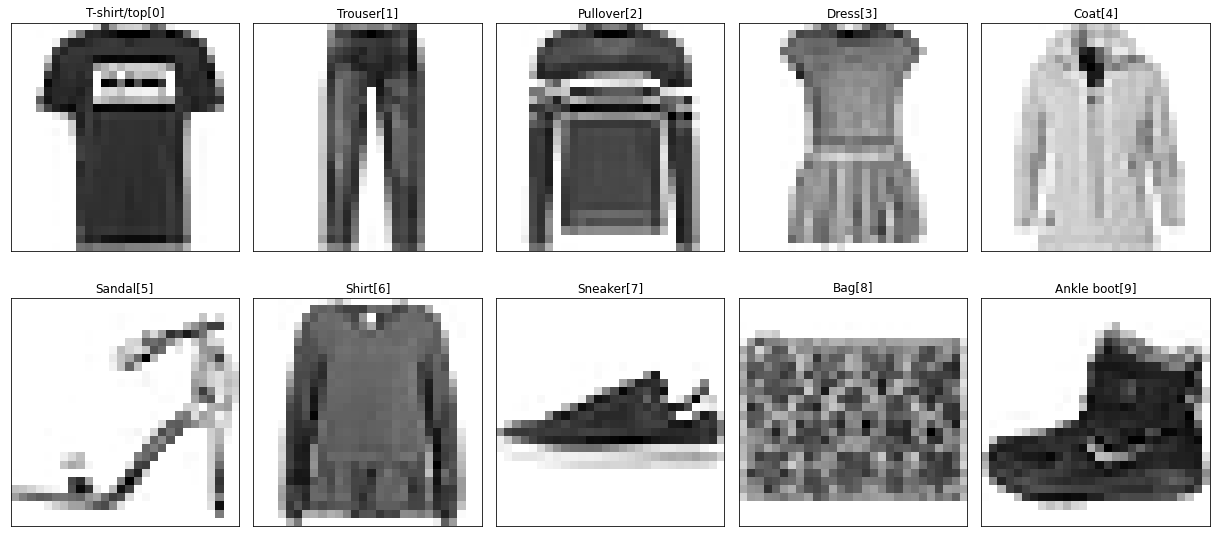

In [136]:
clases = np.sort(df_completo[0].unique())

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


## Ejemplo 1
plt.figure(figsize=(17,8))
for i,clase_i in enumerate(clases):
  filtro_i = y_train == clase_i
  plt.subplot(2,5,i+1)
  plt.title(str(class_names[clase_i])+str([clase_i]))
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(np.array(X_train[filtro_i].iloc[0]).reshape(28,28),cmap='binary')
plt.tight_layout()

2do Ejemplo:

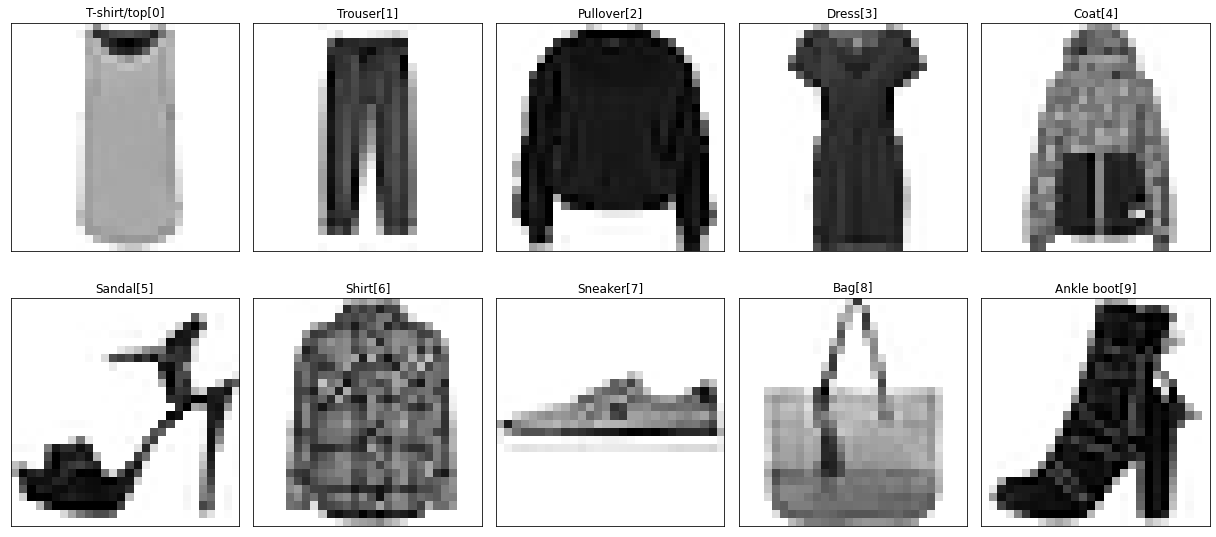

In [138]:
## Ejemplo 2
plt.figure(figsize=(17,8))
for i,clase_i in enumerate(clases):
  filtro_i = y_train == clase_i
  plt.subplot(2,5,i+1)
  plt.title(str(class_names[clase_i])+str([clase_i]))
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(np.array(X_train[filtro_i].iloc[1]).reshape(28,28),cmap='binary')
plt.tight_layout()

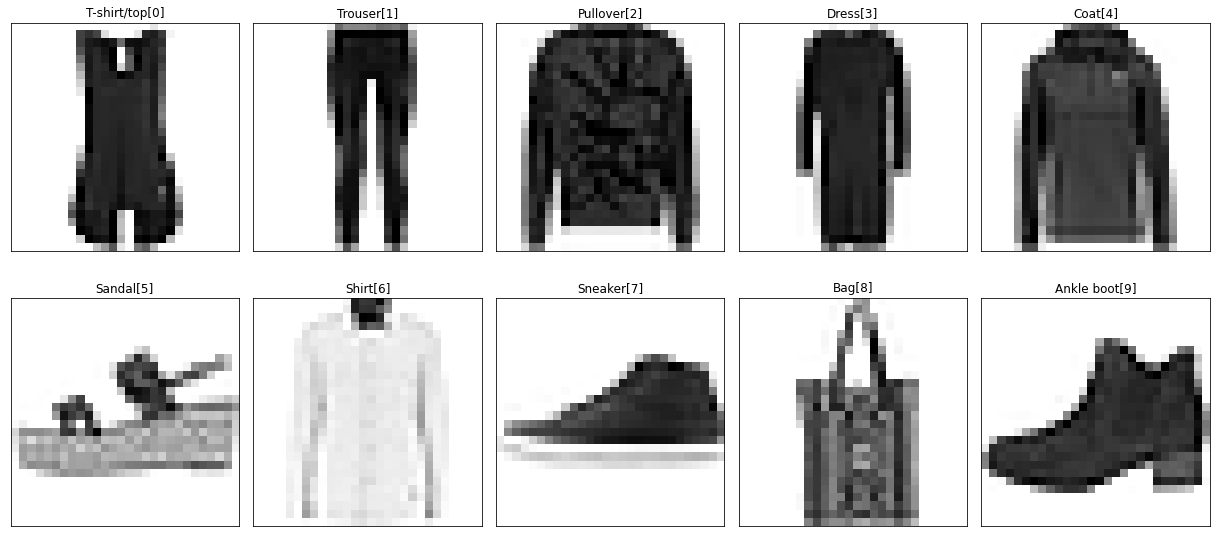

In [137]:
## Ejemplo 3
plt.figure(figsize=(17,8))
for i,clase_i in enumerate(clases):
  filtro_i = y_train == clase_i
  plt.subplot(2,5,i+1)
  plt.title(str(class_names[clase_i])+str([clase_i]))
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(np.array(X_train[filtro_i].iloc[2]).reshape(28,28),cmap='binary')
plt.tight_layout()

## Punto 2: Separación en desarrollo y testeo

Separación de datos respetando la división presente en el github oficial de desarrollo y testeo

In [117]:
X_train.shape

(60000, 784)

In [118]:
y_train.shape

(60000,)

In [119]:
X_test.shape

(10000, 784)

In [120]:
y_test.shape

(10000,)

In [18]:
Q1 = y_train.value_counts().rename("Cant")
P1 = y_train.value_counts(normalize=True).rename("%")

pd.concat([Q1, P1], axis=1).sort_index().rename_axis('train')

,Cant,%
train,,
0,6000,0.1
1,6000,0.1
2,6000,0.1
3,6000,0.1
4,6000,0.1
5,6000,0.1
6,6000,0.1
7,6000,0.1
8,6000,0.1


In [19]:
Q2 = y_test.value_counts().rename("Cant")
P2 = y_test.value_counts(normalize=True).rename("%")

pd.concat([Q2, P2], axis=1).sort_index().rename_axis('test')

,Cant,%
test,,
0,1000,0.1
1,1000,0.1
2,1000,0.1
3,1000,0.1
4,1000,0.1
5,1000,0.1
6,1000,0.1
7,1000,0.1
8,1000,0.1


## Punto 3: Separación del conjunto de desarrollo en entrenamiento y validación

Conjunto de entrenamiento (85.71%):
* x_train, y_train = 80% del conjunto de entrenamiento
* x_val, y_val = 20% del conjunto de entrenamiento

Conjunto de testing(14.29%)
* X_test, y_test = Conjunto held-out de testing

In [20]:
from sklearn.model_selection import train_test_split
seed = 42

x_train, x_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=seed, stratify = y_train) 

## Punto 4: Entrenamiento inicial de modelos

* Boosting
 
* Bagging

* Naive Bayes

* Arbon de decisión


Entrenamiento de 4 modelos con sus hiperparámetros por defecto

#### Se definen funciones para generar el reporte con la metricas de evaluación relevantes
* **precision**     [por clase **+** average: macro y weighted]

* **recall**        [por clase **+** average: macro y weighted]	

* **f1-score**	    [por clase **+** average: macro y weighted]

* **roc_auc**       [por clase **+** average: macro y weighted]

* **Accuracy**

In [21]:
#https://stackoverflow-com.translate.goog/questions/39685740/calculate-sklearn-roc-auc-score-for-multi-class?_x_tr_sl=es&_x_tr_tl=en&_x_tr_hl=es&_x_tr_pto=wapp
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):

  #creating a set of all the unique classes using the actual class list
  unique_class = set(actual_class)
  roc_auc_dict = {}
  for per_class in unique_class:
    #creating a list of all the classes except the current class 
    other_class = [x for x in unique_class if x != per_class]

    #marking the current class as 1 and all other classes as 0
    new_actual_class = [0 if x in other_class else 1 for x in actual_class]
    new_pred_class = [0 if x in other_class else 1 for x in pred_class]

    #using the sklearn metrics method to calculate the roc_auc_score
    roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
    roc_auc_dict[per_class] = roc_auc

  return roc_auc_dict

def classif_report(true_vals, pred_vals):
    n_class = y_val.nunique()
    sk_report = classification_report(true_vals, pred_vals, output_dict=True)
    reportA = pd.DataFrame(sk_report).stack().unstack(0).iloc[0:n_class] 
    reportA['roc_auc'] = [v for k,v in roc_auc_score_multiclass(true_vals, pred_vals, average = "macro").items()]
    acc_score = [sk_report['accuracy']]*5
    macro_avg = reportA.mean()
    weighted_avg = np.average(reportA, axis = 0, weights=reportA.support)
    reportB = pd.DataFrame({"accuracy":acc_score,
                            "macro_avg": macro_avg,
                            "weighted_avg":weighted_avg}).stack().unstack(0)
    report = pd.concat([reportA, reportB], axis=0)
                            
    return report

### Boosting

* GradientBoostingClassifier

#### GradientBoostingClassifier

In [26]:
seed = 42

In [36]:
gbc = GradientBoostingClassifier(random_state = seed, verbose=1)
gbc.fit(x_train, y_train)
y_pred = gbc.predict(x_val)

print("Accuracy training : {:.3f}".format(gbc.score(x_train, y_train)))
print("Accuracy val: {:.3f}".format(gbc.score(x_val, y_val)))
classif_report(y_val, y_pred)

      Iter       Train Loss   Remaining Time 
         1           1.8519          100.87m
         2           1.6078          101.94m
         3           1.4292           96.04m


KeyboardInterrupt: 

Guardo el modelo entrenado en un archivo pickle

In [ ]:
with open('models/gradientboostclassifier_base.pkl', 'wb') as modelFile:
   pickle.dump(gbc, modelFile)

In [ ]:
with open('models/gradientboostclassifier_base.pkl','rb') as modelFile:
     gbc = pickle.load(modelFile)

### Bagging

* Random Forest Classifier

* Bagging decision trees

#### Random Forest Classifier

In [20]:
rf = RandomForestClassifier(random_state = seed, verbose=1, n_jobs=-1)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_val)

print("Accuracy training : {:.3f}".format(rf.score(x_train, y_train)))
print("Accuracy val: {:.3f}".format(rf.score(x_val, y_val)))
classif_report(y_val, y_pred)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s


Accuracy training : 1.000


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished


Accuracy val: 0.883


,precision,recall,f1-score,support,roc_auc
0,0.833200,0.870000,0.851203,1200.000000,0.925324
1,0.993168,0.969167,0.981021,1200.000000,0.984213
2,0.772727,0.807500,0.789731,1200.000000,0.890556
3,0.880452,0.908333,0.894176,1200.000000,0.947315
4,0.772370,0.820000,0.795473,1200.000000,0.896574
5,0.964942,0.963333,0.964137,1200.000000,0.979722
6,0.750501,0.624167,0.681529,1200.000000,0.800556
7,0.939217,0.940000,0.939608,1200.000000,0.966620
8,0.963756,0.975000,0.969345,1200.000000,0.985463
9,0.949124,0.948333,0.948729,1200.000000,0.971343


Guardo el modelo en un archivo pickle

In [21]:
with open('models/random_forest_base.pkl', 'wb') as modelFile:
   pickle.dump(rf, modelFile)

In [22]:
with open('models/random_forest_base.pkl', 'rb') as modelFile:
     rf = pickle.load(modelFile)

#### Bagging decision trees

Alternativa al random forest

In [9]:
dt = DecisionTreeClassifier(random_state=seed)
bdt = BaggingClassifier(dt, random_state = seed, verbose=1, n_jobs=-1)

bdt.fit(x_train, y_train)
y_pred = bdt.predict(x_val)

print("Accuracy training : {:.3f}".format(bdt.score(x_train, y_train)))
print("Accuracy val: {:.3f}".format(bdt.score(x_val, y_val)))
classif_report(y_val, y_pred)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.7min remaining:  1.7min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.0min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.1s remaining:    2.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Accuracy training : 0.994


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s finished


Accuracy val: 0.858


,precision,recall,f1-score,support,roc_auc
0,0.793638,0.852500,0.822017,1200.000000,0.913935
1,0.977368,0.971667,0.974509,1200.000000,0.984583
2,0.734148,0.800833,0.766042,1200.000000,0.884306
3,0.855870,0.880833,0.868172,1200.000000,0.932176
4,0.755328,0.738333,0.746734,1200.000000,0.855880
5,0.937811,0.942500,0.940150,1200.000000,0.967778
6,0.700201,0.580000,0.634458,1200.000000,0.776204
7,0.911837,0.930833,0.921237,1200.000000,0.960417
8,0.945724,0.958333,0.951987,1200.000000,0.976111
9,0.951724,0.920000,0.935593,1200.000000,0.957407


Guardo el modelo en un archivo pickle

In [24]:
with open('models/baggingdt_base.pkl', 'wb') as modelFile:
   pickle.dump(bdt, modelFile)

In [25]:
with open('models/baggingdt_base.pkl', 'rb') as modelFile:
     bdt = pickle.load(modelFile)

### Árbol de decisión

In [25]:
ad = DecisionTreeClassifier(random_state = seed)
ad.fit(x_train, y_train)
y_pred = ad.predict(x_val)

print("Accuracy training : {:.3f}".format(ad.score(x_train, y_train)))
print("Accuracy val: {:.3f}".format(ad.score(x_val, y_val)))
classif_report(y_val, y_pred)

Guardo el modelo en un archivo pickle

In [14]:
with open('models/dt_base.pkl', 'wb') as modelFile:
   pickle.dump(ad, modelFile)

In [15]:
with open('models/dt_base.pkl','rb') as modelFile:
     ad = pickle.load(modelFile)

### Naive Bayes

In [17]:
nb = MultinomialNB(alpha=1.0) #alpha = 1.0 es el default 
nb.fit(x_train, y_train)

y_pred = nb.predict(x_val)
print("Accuracy training : {:.3f}".format(nb.score(x_train, y_train)))
print("Accuracy val: {:.3f}".format(nb.score(x_val, y_val)))
classif_report(y_val, y_pred)

Accuracy training : 0.666
Accuracy val: 0.668


,precision,recall,f1-score,support,roc_auc
0,0.748617,0.789167,0.768357,1200.000000,0.879861
1,0.984404,0.894167,0.937118,1200.000000,0.946296
2,0.624021,0.597500,0.610473,1200.000000,0.778750
3,0.665416,0.886667,0.760272,1200.000000,0.918565
4,0.460134,0.630000,0.531833,1200.000000,0.773935
5,0.691176,0.156667,0.255435,1200.000000,0.574444
6,0.322414,0.155833,0.210112,1200.000000,0.559722
7,0.595329,0.913333,0.720816,1200.000000,0.922176
8,0.887198,0.825833,0.855416,1200.000000,0.907083
9,0.686981,0.826667,0.750378,1200.000000,0.892407


Guardo el modelo en un archivo pickle

In [18]:
with open('models/naivebayes_base.pkl', 'wb') as modelFile:
   pickle.dump(nb, modelFile)

In [19]:
with open('models/naivebayes_base.pkl','rb') as modelFile:
     nb = pickle.load(modelFile)

### Métricas relevantes para el problema en el conjunto de validación

Las metricas ya estan calculadas para cada modelo (ver arriba)

Se calcularon todas las metricas que consideramos relevantes, que nos muestran la capacidad de prediccion del modelo por cada clase y de manera global:
* **precision**     [por clase **+** average]

* **recall**        [por clase **+** average]	

* **f1-score**	    [por clase **+** average]

* **roc_auc**       [por clase **+** average]

* **Accuracy**

### Justificación

Se realiza la apertura de la metrica por clase, para poder ver el desempeño del modelo clasificando cada clase en particular:
- Para evitar perder el detalle comparando el desempeño en cada una con un modelo aleatorio y descubrir si predice en algun caso por debajo de ese umbral minimo (0,5)
- tiene algun especial desequilibro entre precision y recall en alguna clase en particular
- y poder comparar el desempeño en c/u, sabiendo el modelo cuales predice mejor y cuales le cuesta mas.

Con cada una de estas metricas buscamos ver:
* Precision: vemos la tasa de predichos en la clase correcta sobre el total predecido como esa clase
* Recall: vemos que % encuentra del total existente en esa clase
* f1-score: obtenemos una media armonica entre precision y recall
* roc-auc: como un resumen de la calidad de las predicciones positivas del modelo, que proporción de la clase son predichos correctamente del total existente (tasa de verdaderos positivo) vs los que clasifica erradamente (tasa de falsos positivos) sobre los negativos reales.

El average nos entrega una medida global del modelo en su conjunto:
Y al tratarse de un dataset perfectamente balanceado, el promedio es un buen indicador, sopesando cada clase por igual.

Y como medida global unica para evaluar el modelo: usamos el Accuracy, que nos otorga un buen resumen de la performance del modelo, resumiendo su matriz de confusión en un unico valor, que si bien puede ocultarnos información del desempeño de cada clase en particular, al igual que los average, por tratarse un de un conjunto de datos balanceado, nos brinda una buena medida resumen general.

## Punto 5: Exploración de modelo Random Forest

In [22]:
#La función crea un csv
def ensemble_exploring(xtrain, ytrain, xval, yval, model="random forest", 
                params={'n_estimators': None,
                               'max_depth': None},
                results_folder=None):
    for key,values in tqdm(params.items()):
        if model=="random forest":
            print(f"Exploring {model} classifier")
            start = time.time()
            clf = RandomForestClassifier(random_state=42)
        elif model == "gradient boosting": 
            print(f"Exploring {model} classifier")
            start = time.time()
            clf = GradientBoostingClassifier(random_state=42)
        else: 
            print("Model must be 'gradient boosting' or 'random forest'")
            break
        scores = []
        max_n_est = None #esto es para iterar fijando este parámetro
        for v in tqdm(values):  
            if max_n_est: 
                p = {key:v, "n_estimators":max_n_est}
            else:
                p = {key:v}
            clf.set_params(**p)
            clf.fit(x_train, y_train)
            stop = time.time()
            y_pred = clf.predict(x_val)
            result_dict = {key:v, 'training_acc':clf.score(xtrain, ytrain), 'test_acc':clf.score(xval, yval), 'time':stop-start}
            scores.append(result_dict)
        today = datetime.now().strftime("%Y%m%d")
        path = f"{results_folder}/results_{model.replace(' ','_')}_parm_{key}_{today}.csv"
        results = pd.DataFrame(scores).set_index(key)
        results.to_csv(path)
        if key == "n_estimators":
            max_n_est = int(results[['test_acc']].idxmax())

In [2]:
img_folder= "./img"
                
from pathlib import Path
Path(img_folder).mkdir(parents=True, exist_ok=True)

result_folder= "./results"
                
from pathlib import Path
Path(result_folder).mkdir(parents=True, exist_ok=True)

#######################################################
### ESTA PARTE YA SE CORRIO
######################################################
# rf_params = params={'n_estimators': range(50, 501, 50),
#                     'max_depth': range(10, 101, 10)}
# ensemble_exploring(x_train, y_train, x_val, y_val, 
#                    model="random forest",
#                    params=rf_params,
#                    results_folder = result_folder)


Grafico las distintas métricas para cada valor de n_estimators

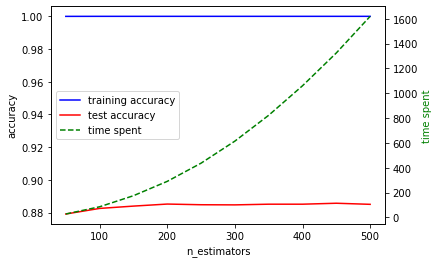

In [41]:
model = "random forest"
parameter = "n_estimators"
lastdate = "20220608" #chequear el ultimo archivo para levantar
input_path = f"./results/results_{model.replace(' ','_')}_parm_{parameter}_{lastdate}.csv" #armo el path para levantar el csv correcto

scores_rf_df = pd.read_csv(input_path)

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
p1 = ax1.plot(scores_rf_df[parameter], scores_rf_df.training_acc, 'b-', label = 'training accuracy')
p2 = ax1.plot(scores_rf_df[parameter], scores_rf_df.test_acc, 'r-', label = 'test accuracy')
p3 = ax2.plot(scores_rf_df[parameter], scores_rf_df.time, 'g--', label = 'time spent')

ax1.set_xlabel(parameter)
ax1.set_ylabel('accuracy')
ax2.set_ylabel('time spent', color='g')

# added these three lines
lgs = p1+p2+p3
labs = [l.get_label() for l in lgs]
ax1.legend(lgs, labs, loc="center left")

output_path =  f"./results/results_{model.replace(' ','_')}_parm_{parameter}_{lastdate}.png"

#plt.show()
plt.savefig(output_path, dpi=200, facecolor="white")

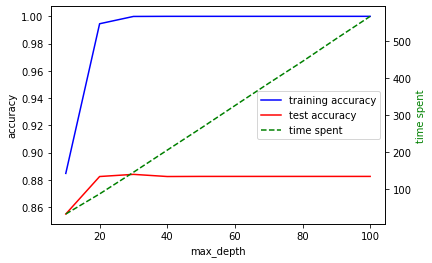

In [44]:
model = "random forest"
parameter = "max_depth"
lastdate = "20220608" #chequear el ultimo archivo para levantar
input_path = f"./results/results_{model.replace(' ','_')}_parm_{parameter}_{lastdate}.csv" #armo el path para levantar el csv correcto

scores_rf_df = pd.read_csv(input_path)

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
p1 = ax1.plot(scores_rf_df[parameter], scores_rf_df.training_acc, 'b-', label = 'training accuracy')
p2 = ax1.plot(scores_rf_df[parameter], scores_rf_df.test_acc, 'r-', label = 'test accuracy')
p3 = ax2.plot(scores_rf_df[parameter], scores_rf_df.time, 'g--', label = 'time spent')

ax1.set_xlabel(parameter)
ax1.set_ylabel('accuracy')
ax2.set_ylabel('time spent', color='g')

# added these three lines
lgs = p1+p2+p3
labs = [l.get_label() for l in lgs]
ax1.legend(lgs, labs, loc="best")

output_path =  f"./results/results_{model.replace(' ','_')}_parm_{parameter}_{lastdate}.png"

#plt.show()
plt.savefig(output_path, dpi=200, facecolor="white")

## Punto 6: Exploración de modelo Gradient Boosting Machine

In [12]:
img_folder= "./img"
                
from pathlib import Path
Path(img_folder).mkdir(parents=True, exist_ok=True)

result_folder= "./results"
                
from pathlib import Path
Path(result_folder).mkdir(parents=True, exist_ok=True)

#Falta correr esta parte. 
gb_params = params={'n_estimators': [10,50,100,150,200],
                    'max_depth': [1,3,5,7,9]}

ensemble_exploring(x_train, y_train, x_val, y_val, 
                   model="gradient boosting",
                   params=gb_params,
                   results_folder = result_folder)


  0%|          | 0/2 [00:00<?, ?it/s]

Exploring gradient boosting classifier


 50%|█████     | 1/2 [2:30:52<2:30:52, 9052.10s/it]

Exploring gradient boosting classifier


 50%|█████     | 1/2 [22:57:16<22:57:16, 82636.07s/it]


KeyboardInterrupt: 

In [ ]:
model = "gradient boosting"
parameter = "n_estimators"
lastdate = "20220608" #chequear el ultimo archivo para levantar
input_path = f"./results/results_{model.replace(' ','_')}_parm_{parameter}_{lastdate}.csv" #armo el path para levantar el csv correcto

scores_gb_df = pd.read_csv(input_path)

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
p1 = ax1.plot(scores_gb_df[parameter], scores_gb_df.training_acc, 'b-', label = 'training accuracy')
p2 = ax1.plot(scores_gb_df[parameter], scores_gb_df.test_acc, 'r-', label = 'test accuracy')
p3 = ax2.plot(scores_gb_df[parameter], scores_gb_df.time, 'g--', label = 'time spent')

ax1.set_xlabel(parameter)
ax1.set_ylabel('accuracy')
ax2.set_ylabel('time spent', color='g')

# added these three lines
lgs = p1+p2+p3
labs = [l.get_label() for l in lgs]
ax1.legend(lgs, labs, loc="best")

output_path =  f"./results/results_{model.replace(' ','_')}_parm_{parameter}_{lastdate}.png"

plt.savefig(output_path, dpi=200, facecolor="white")

In [ ]:
model = "gradient boosting"
parameter = "max_depth"
lastdate = "20220608" #chequear el ultimo archivo para levantar
input_path = f"./results/results_{model.replace(' ','_')}_parm_{parameter}_{lastdate}.csv" #armo el path para levantar el csv correcto

scores_gb_df = pd.read_csv(input_path)

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
p1 = ax1.plot(scores_gb_df[parameter], scores_gb_df.training_acc, 'b-', label = 'training accuracy')
p2 = ax1.plot(scores_gb_df[parameter], scores_gb_df.test_acc, 'r-', label = 'test accuracy')
p3 = ax2.plot(scores_gb_df[parameter], scores_gb_df.time, 'g--', label = 'time spent')

ax1.set_xlabel(parameter)
ax1.set_ylabel('accuracy')
ax2.set_ylabel('time spent', color='g')

# added these three lines
lgs = p1+p2+p3
labs = [l.get_label() for l in lgs]
ax1.legend(lgs, labs, loc="best")

output_path =  f"./results/results_{model.replace(' ','_')}_parm_{parameter}_{lastdate}.png"

plt.savefig(output_path, dpi=200, facecolor="white")

## Punto 7: Análisis de mejores modelos obtenidos de Random Forest y Gradient Boosting Machine

### Vuelvo a entrenar los modelos anteriores, pero con los hiperparámetros óptimos

PASO 1: Recupero los Conjuntos de Datos originales
* Desarrollo: X_dev, y_dev

* Test: X_test, y_test


In [23]:
# Verificamos conjunto desarrollo -> 60mil registros
X_dev = X_train
y_dev = df_entrenamiento[0]

print(X_dev.shape, ' + ', y_dev.shape)

(60000, 784)  +  (60000,)


In [24]:
# Verificamos conjunto de Test -> 10mil registros

print(X_test.shape, ' + ', y_test.shape)

(10000, 784)  +  (10000,)


PASO 2: Recupero los mejores parametros de cada modelo -> re-entrenamos los modelos usando esos parametros y con todo el dataset de desarrollo

#### Random Forest

In [25]:
# Mejores Parametros Random Forest:
n_estimators_rf = 450
max_depth_rf = 30

In [26]:
print(f'los hiperparámetros óptimos del random forest son nº estimators = {n_estimators_rf} y max_depth = {max_depth_rf}')  # leerlos del csv

los hiperparámetros óptimos del random forest son nº estimators = 450 y max_depth = 30


In [27]:
rfo = RandomForestClassifier(random_state = 42, verbose=1, n_jobs=-1, n_estimators=n_estimators_rf, max_depth=max_depth_rf)
rfo.fit(X_dev, y_dev)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  2.4min finished


RandomForestClassifier(max_depth=30, n_estimators=450, n_jobs=-1,
                       random_state=42, verbose=1)

Guardo el modelo en un archivo pickle

In [28]:
with open('models/random_forest_opt.pkl', 'wb') as modelFile:
   pickle.dump(rfo, modelFile)

In [ ]:
with open('models/random_forest_opt.pkl','rb') as modelFile:
     rfo = pickle.load(modelFile)

#### Gradient boosting machines

In [29]:
# Mejores Parametros Gradient Boosting:
n_estimators_gb = 50
max_depth_gb = 7


In [30]:
print(f'los hiperparámetros óptimos del gradient boosting machines son nº estimators = {n_estimators_gb} y max_depth = {max_depth_gb}')  # leerlos del csv

los hiperparámetros óptimos del gradient boosting machines son nº estimators = 50 y max_depth = 7


In [31]:
gbmo = GradientBoostingClassifier(random_state=42, n_estimators = n_estimators_gb, max_depth = max_depth_gb)
gbmo.fit(X_dev, y_dev)

GradientBoostingClassifier(max_depth=7, n_estimators=50, random_state=42)

Guardo el modelo en un archivo pickle

In [32]:
with open('models/gradientboostingmachines_opt.pkl', 'wb') as modelFile:
   pickle.dump(gbmo, modelFile)

### Evaluación sobre el conjunto de test

In [33]:
# Verificamos conjunto de Test -> 10mil registros

print(X_test.shape, ' + ', y_test.shape)

(10000, 784)  +  (10000,)


Definimos funcion para generar el reporte de metricas:

In [177]:
def preatty_classif_report(y_test, y_pred):
    f = ['accuracy', 'macro_avg', 'weighted_avg']
    nombres = ['T-shirt/top [0]', 'Trouser [1]', 'Pullover [2]', 'Dress [3]', 'Coat [4]', 'Sandal [5]', 'Shirt [6]', 'Sneaker [7]', 'Bag [8]', 'Ankle boot [9]']
    index_rep = nombres + f
        
    dfc= classif_report(y_test, y_pred).round(3)
    dfc.loc[f,'support'] = len(y_test)
    dfc.support = dfc.support.astype(int)
    dfc = dfc[['precision', 'recall', 'f1-score', 'roc_auc', 'support']]
    dfc.index = index_rep
    return dfc

Evaluamos el Modelo de Random Forest

In [ ]:
# Predecimos con el modelo de Random Forest optimizado, sobre el conjunto de test original:
y_rfpred = rfo.predict(X_test)

In [221]:
# Analizamos los resultados obtenido, con las metricas de evaluación: accuracy, precision, recall, f1-score, roc_auc
eval_rf = preatty_classif_report(y_test, y_rfpred)
eval_rf

,precision,recall,f1-score,roc_auc,support
T-shirt/top [0],0.825,0.857,0.841,0.918,1000
Trouser [1],0.994,0.962,0.978,0.981,1000
Pullover [2],0.774,0.806,0.789,0.890,1000
Dress [3],0.881,0.914,0.897,0.950,1000
Coat [4],0.769,0.824,0.796,0.898,1000
Sandal [5],0.977,0.958,0.967,0.978,1000
Shirt [6],0.718,0.593,0.650,0.784,1000
Sneaker [7],0.928,0.952,0.940,0.972,1000
Bag [8],0.962,0.975,0.968,0.985,1000
Ankle boot [9],0.953,0.949,0.951,0.972,1000


Evaluamos el Modelo de Gradient Boosting

In [172]:
# # Predecimos con el modelo de Gradient Boosting optimizado, sobre el conjunto de test original:
y_gbpred = gbmo.predict(X_test)

In [188]:
# Analizamos los resultados obtenido, con las metricas de evaluación: accuracy, precision, recall, f1-score, roc_auc
eval_gb = preatty_classif_report(y_test, y_gbpred)
eval_gb

,precision,recall,f1-score,roc_auc,support
T-shirt/top [0],0.825,0.860,0.842,0.920,1000
Trouser [1],0.993,0.955,0.973,0.977,1000
Pullover [2],0.773,0.796,0.784,0.885,1000
Dress [3],0.878,0.902,0.890,0.944,1000
Coat [4],0.782,0.812,0.797,0.893,1000
Sandal [5],0.976,0.960,0.968,0.979,1000
Shirt [6],0.698,0.623,0.658,0.796,1000
Sneaker [7],0.936,0.955,0.946,0.974,1000
Bag [8],0.963,0.967,0.965,0.981,1000
Ankle boot [9],0.952,0.951,0.951,0.973,1000


### Comparación de modelos y Análisis de resultados en base a métricas elegidas

#### Análisis de métricas

In [223]:
# Comparamos los resultados de los dos modelos:
eval_rf['Rf || Gb'] = '<---||--->'

pd.concat([eval_rf, eval_gb], axis=1)

,precision,recall,f1-score,roc_auc,support,Rf || Gb,precision,recall,f1-score,roc_auc,support
T-shirt/top [0],0.825,0.857,0.841,0.918,1000,<---||--->,0.825,0.860,0.842,0.920,1000
Trouser [1],0.994,0.962,0.978,0.981,1000,<---||--->,0.993,0.955,0.973,0.977,1000
Pullover [2],0.774,0.806,0.789,0.890,1000,<---||--->,0.773,0.796,0.784,0.885,1000
Dress [3],0.881,0.914,0.897,0.950,1000,<---||--->,0.878,0.902,0.890,0.944,1000
Coat [4],0.769,0.824,0.796,0.898,1000,<---||--->,0.782,0.812,0.797,0.893,1000
Sandal [5],0.977,0.958,0.967,0.978,1000,<---||--->,0.976,0.960,0.968,0.979,1000
Shirt [6],0.718,0.593,0.650,0.784,1000,<---||--->,0.698,0.623,0.658,0.796,1000
Sneaker [7],0.928,0.952,0.940,0.972,1000,<---||--->,0.936,0.955,0.946,0.974,1000
Bag [8],0.962,0.975,0.968,0.985,1000,<---||--->,0.963,0.967,0.965,0.981,1000
Ankle boot [9],0.953,0.949,0.951,0.972,1000,<---||--->,0.952,0.951,0.951,0.973,1000


escribir analisis sobre las metricas y comparar los modelos
--> parece que el meor modelo es el Random Rorest (por muy poquito)

### Conclusión sobre mejor modelo

nombres

### Punto 8: Matriz de confusión de mejor modelo y su analisis

In [224]:
# Creamos la matriz de confusion:
from sklearn.metrics import confusion_matrix
import seaborn as sns

nombres = ['T-shirt/top [0]', 'Trouser [1]', 'Pullover [2]', 'Dress [3]', 'Coat [4]', 'Sandal [5]', 'Shirt [6]', 'Sneaker [7]', 'Bag [8]', 'Ankle boot [9]']
clases = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
dicc = dict(zip(clases, nombres))


matriz = confusion_matrix(y_test, y_rfpred)
df_mc = pd.DataFrame(matriz, index=nombres, columns=nombres)
#df_mc.index.map(dicc)
#df_mc.columns.map(dicc)

df_mc

,T-shirt/top [0],Trouser [1],Pullover [2],Dress [3],Coat [4],Sandal [5],Shirt [6],Sneaker [7],Bag [8],Ankle boot [9]
T-shirt/top [0],857,0,9,29,5,1,88,0,11,0
Trouser [1],2,962,2,20,4,0,9,0,1,0
Pullover [2],13,0,806,10,116,0,51,0,4,0
Dress [3],15,2,11,914,28,0,28,0,2,0
Coat [4],1,1,89,33,824,0,50,0,2,0
Sandal [5],0,0,0,1,0,958,0,29,1,11
Shirt [6],151,1,123,28,88,0,593,0,16,0
Sneaker [7],0,0,0,0,0,12,0,952,0,36
Bag [8],0,2,2,2,6,2,7,4,975,0
Ankle boot [9],0,0,0,0,0,8,0,41,2,949


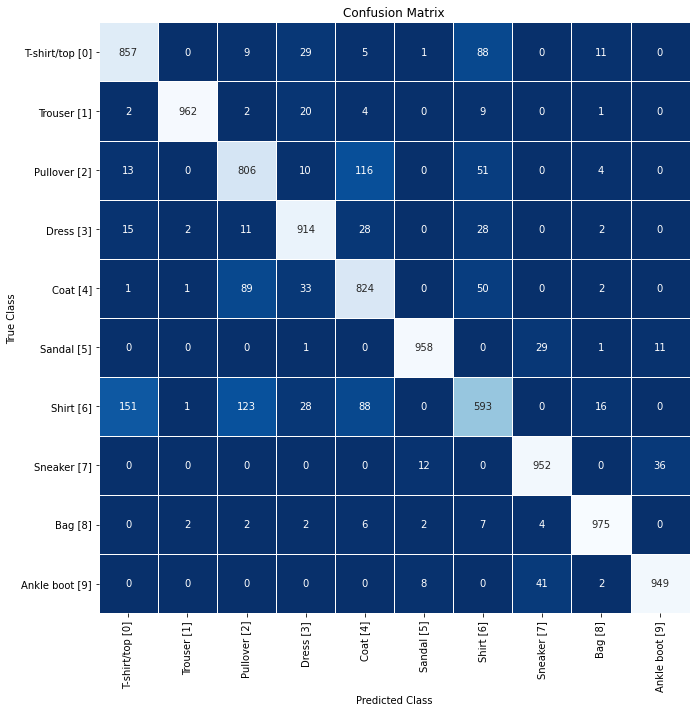

In [225]:
# graficamos la matriz de confusion

plt.figure(figsize=(10,10))
sns.heatmap(df_mc, annot=True, linewidths=.5, fmt=".0f", square = True, cmap = 'Blues_r', cbar=None ).set(xlabel='Predicted Class', ylabel='True Class')
plt.title("Confusion Matrix"), plt.tight_layout()
plt.show()

In [96]:
plt.savefig("./img/confusion_matrix.png", dpi=200, facecolor="white")

<Figure size 432x288 with 0 Axes>

In [ ]:
""" # graficamos la matriz de confusion
fig, ax =plt.subplots(figsize=(4.5,4.5))

g = sns.heatmap(df_mc, annot=True, linewidths=.5, fmt=".0f", square = True, cmap = 'Blues_r', cbar=None, ax=ax,  annot_kws={"size": 15}, linecolor="black")
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 15)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 15)
ax.set_xlabel('Clase Predicha', fontsize=16)
ax.set_ylabel('Clase Verdadera', fontsize=16)
ax.set_title("Confusion Matrix", fontsize=18)
plt.tight_layout()
plt.savefig("./img/cm-modelo-base.png", dpi=200, facecolor="white")""" 

## Punto 9: Estabilidad del modelo frente al ruido

### Datos faltantes

In [ ]:
from itertools import product
from random import sample

p = 0.1 #Proporción de 0s a introducir
n = int(X_test.shape[0]*X_test.shape[1]*p)          #Calculate count of nans. Reemplazar nombre del dataframe

#Sample exactly n indexes
ids = sample(list(product(range(X_test.shape[0]), range(X_test.shape[1]))), n)
idx, idy = list(zip(*ids))

data = X_test.to_numpy().astype(float)            #Get data as numpy
data[idx, idy] = 0                         

#Assign to new dataframe
ruido_zeros = pd.DataFrame(data, columns=X_test.columns, index=X_test.index)


### Rotación de imágenes

In [ ]:
ruido_rotacion = ruido_zeros[ruido_zeros.columns[::-1]]

## Redes Neuronales

In [31]:
import tensorflow as tf
import tensorflow.keras.layers as tfkl
from tensorflow.keras.datasets import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

ohe = OneHotEncoder()
train_labels = ohe.fit_transform(train_labels.reshape(-1,1)).toarray()
test_labels = ohe.fit_transform(test_labels.reshape(-1,1)).toarray()

train_images,val_images,train_labels,val_labels = train_test_split(train_images,train_labels,test_size=0.2)

In [51]:
#Voy a hacer una prueba para que teste distintas cantidades de neuronas en la capa oculta
# y además utilice distintas funciones de activación. 
#por otro lado tambien optimiza el batch size. 

def entrenar_modelo(hparams, model_name):
  layer_in = tfkl.Input(shape=(28,28)) #Todo modelo necesita una entrada, y debemos especificar sus dimensiones
  layer_add_channel = tf.expand_dims(layer_in,axis=3)
  conv_block1 = tfkl.Conv2D(16,(3,3),padding='SAME',activation='relu')(layer_add_channel)
  conv_block1 = tfkl.Conv2D(16,(3,3),padding='SAME',activation='relu')(conv_block1)
  pool_1 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_block1) #Aca queda (14,14)
  conv_block2 = tfkl.Conv2D(32,(3,3),padding='SAME',activation='relu')(pool_1)
  conv_block2 = tfkl.Conv2D(32,(3,3),padding='SAME',activation='relu')(conv_block2)
  pool_2 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_block2) #Aca queda (7,7)
  conv_block3 = tfkl.Conv2D(32,(3,3),padding='SAME',activation='relu')(pool_2)
  conv_block3 = tfkl.Conv2D(8,(3,3),padding='SAME',activation='relu')(conv_block3)
  #Esta capa rompe la imagen achicada (8,7,7) y la vuelve un vector de 392 elementos
  flatten_layer = tfkl.Flatten()(conv_block3)
  hidden_layer = tfkl.Dense(units=hparams['units'], activation=hparams['activation'])(flatten_layer)
  #Esta es la capa de salida
  output_layer = tfkl.Dense(units=10,activation='softmax')(flatten_layer)

  conv2d_model = tf.keras.Model(inputs=[layer_in],outputs=[output_layer])
  

  optimizer = tf.keras.optimizers.Adam(learning_rate=hparams['learning_rate'])
  metrics_list = [tf.keras.metrics.CategoricalAccuracy(),
                  tf.keras.metrics.Precision(),
                  tf.keras.metrics.Recall(),
                  tf.keras.metrics.AUC()]
  metric_names = ['loss','acc','precision','recall','auc']
  conv2d_model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=metrics_list)

  cb_list = [tf.keras.callbacks.TensorBoard(log_dir='tblogs'),
              tf.keras.callbacks.ModelCheckpoint(filepath='checkpoints/model.{epoch:02d}-{val_loss:.2f}.ckpt',
                                                 save_weights_only=True),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)]

  start = time.time()
  conv2d_model.fit(x=train_images,y=train_labels,validation_data=(val_images,val_labels),batch_size=hparams['batch_size'],epochs=50,callbacks=cb_list)
  elapsed_time = time.time() - start
  performance = conv2d_model.evaluate(x=val_images,y=val_labels)
  performance = dict(zip(metric_names,performance))

  return conv2d_model, performance, hparams, elapsed_time

In [52]:
from sklearn.model_selection import ParameterSampler

hyperparameter_space = {'units': [32,56,128,512,1024,2048,4096,8192],
                        'activation': ['relu','tanh','sigmoid','elu'],
                        'batch_size':[16,32,64,128,256,512],
                        'learning_rate':[0.0001,0.001,0.01]}
hyperparameters = list(ParameterSampler(hyperparameter_space,n_iter=10))

best_recall = 0
best_model = None
best_params = None
hyp_results = []
for model_name, hparam in tqdm(enumerate(hyperparameters)):
  model, perf, hparams, elapsed_time = entrenar_modelo(hparam ,model_name=str(model_name+1))
  hyp_results.append({'model_name':model_name,'params': hparams,'performance': perf, 'elapsed_time': elapsed_time})  
  if perf['recall'] > best_recall:
    best_recall = perf['recall']
    best_model = model
    model.save_weights(f'./best_conv2d/model_{model_name}')

0it [00:00, ?it/s]

Epoch 1/50
750/750 [==] - 56s 72ms/step - loss: 0.7726 - categorical_accuracy: 0.7334 - precision: 0.8393 - recall: 0.6484 - auc: 0.9648 - val_loss: 0.5168 - val_categorical_accuracy: 0.8223 - val_precision: 0.8585 - val_recall: 0.7809 - val_auc: 0.9831
Epoch 2/50
750/750 [==] - 54s 73ms/step - loss: 0.4387 - categorical_accuracy: 0.8458 - precision: 0.8813 - recall: 0.8102 - auc: 0.9875 - val_loss: 0.4241 - val_categorical_accuracy: 0.8514 - val_precision: 0.8820 - val_recall: 0.8246 - val_auc: 0.9880
Epoch 3/50
750/750 [==] - 54s 71ms/step - loss: 0.3786 - categorical_accuracy: 0.8668 - precision: 0.8942 - recall: 0.8390 - auc: 0.9903 - val_loss: 0.3970 - val_categorical_accuracy: 0.8625 - val_precision: 0.8876 - val_recall: 0.8403 - val_auc: 0.9891
Epoch 4/50
750/750 [==] - 54s 72ms/step - loss: 0.3451 - categorical_accuracy: 0.8779 - precision: 0.9023 - recall: 0.8551 - auc: 0.9918 - val_loss: 0.3604 - val_categorical_accuracy: 0.8738 - val_precision: 0.8997 - val_recall: 0.8540 - 

1it [19:55, 1195.15s/it]

Epoch 1/50
375/375 [==] - 49s 128ms/step - loss: 1.3781 - categorical_accuracy: 0.6199 - precision_1: 0.7237 - recall_1: 0.5185 - auc_1: 0.9133 - val_loss: 0.6698 - val_categorical_accuracy: 0.7673 - val_precision_1: 0.8319 - val_recall_1: 0.7067 - val_auc_1: 0.9732
Epoch 2/50
375/375 [==] - 48s 127ms/step - loss: 0.5698 - categorical_accuracy: 0.8015 - precision_1: 0.8507 - recall_1: 0.7510 - auc_1: 0.9798 - val_loss: 0.5336 - val_categorical_accuracy: 0.8109 - val_precision_1: 0.8598 - val_recall_1: 0.7679 - val_auc_1: 0.9821
Epoch 3/50
375/375 [==] - 47s 126ms/step - loss: 0.4778 - categorical_accuracy: 0.8335 - precision_1: 0.8723 - recall_1: 0.7946 - auc_1: 0.9853 - val_loss: 0.4760 - val_categorical_accuracy: 0.8328 - val_precision_1: 0.8692 - val_recall_1: 0.7966 - val_auc_1: 0.9853
Epoch 4/50
375/375 [==] - 47s 126ms/step - loss: 0.4297 - categorical_accuracy: 0.8491 - precision_1: 0.8822 - recall_1: 0.8169 - auc_1: 0.9877 - val_loss: 0.4457 - val_categorical_accuracy: 0.8422 -

2it [4:56:08, 10241.44s/it]

Epoch 1/50
188/188 [==] - 42s 218ms/step - loss: 1.2905 - categorical_accuracy: 0.6213 - precision_2: 0.7510 - recall_2: 0.4975 - auc_2: 0.9124 - val_loss: 0.6831 - val_categorical_accuracy: 0.7673 - val_precision_2: 0.8324 - val_recall_2: 0.6984 - val_auc_2: 0.9719
Epoch 2/50
188/188 [==] - 41s 221ms/step - loss: 0.5882 - categorical_accuracy: 0.7949 - precision_2: 0.8482 - recall_2: 0.7416 - auc_2: 0.9789 - val_loss: 0.5374 - val_categorical_accuracy: 0.8148 - val_precision_2: 0.8596 - val_recall_2: 0.7705 - val_auc_2: 0.9817
Epoch 3/50
188/188 [==] - 40s 211ms/step - loss: 0.4906 - categorical_accuracy: 0.8278 - precision_2: 0.8685 - recall_2: 0.7890 - auc_2: 0.9847 - val_loss: 0.4796 - val_categorical_accuracy: 0.8336 - val_precision_2: 0.8693 - val_recall_2: 0.7994 - val_auc_2: 0.9851
Epoch 4/50
188/188 [==] - 40s 210ms/step - loss: 0.4405 - categorical_accuracy: 0.8436 - precision_2: 0.8780 - recall_2: 0.8118 - auc_2: 0.9872 - val_loss: 0.4434 - val_categorical_accuracy: 0.8480 -

3it [5:17:22, 6146.71s/it] 

Epoch 1/50
375/375 [==] - 45s 119ms/step - loss: 0.6850 - categorical_accuracy: 0.7636 - precision_3: 0.8459 - recall_3: 0.7009 - auc_3: 0.9732 - val_loss: 0.4215 - val_categorical_accuracy: 0.8477 - val_precision_3: 0.8742 - val_recall_3: 0.8198 - val_auc_3: 0.9881
Epoch 2/50
375/375 [==] - 44s 118ms/step - loss: 0.4164 - categorical_accuracy: 0.8480 - precision_3: 0.8781 - recall_3: 0.8190 - auc_3: 0.9888 - val_loss: 0.4220 - val_categorical_accuracy: 0.8489 - val_precision_3: 0.8727 - val_recall_3: 0.8294 - val_auc_3: 0.9875
Epoch 3/50
375/375 [==] - 44s 118ms/step - loss: 0.3919 - categorical_accuracy: 0.8552 - precision_3: 0.8817 - recall_3: 0.8313 - auc_3: 0.9898 - val_loss: 0.3657 - val_categorical_accuracy: 0.8626 - val_precision_3: 0.8914 - val_recall_3: 0.8364 - val_auc_3: 0.9913
Epoch 4/50
375/375 [==] - 44s 118ms/step - loss: 0.3754 - categorical_accuracy: 0.8618 - precision_3: 0.8866 - recall_3: 0.8387 - auc_3: 0.9906 - val_loss: 0.3769 - val_categorical_accuracy: 0.8641 -

4it [5:27:43, 3964.98s/it]

Epoch 1/50
3000/3000 [==] - 61s 20ms/step - loss: 0.7359 - categorical_accuracy: 0.7337 - precision_4: 0.8078 - recall_4: 0.6590 - auc_4: 0.9692 - val_loss: 0.7103 - val_categorical_accuracy: 0.7444 - val_precision_4: 0.7870 - val_recall_4: 0.7160 - val_auc_4: 0.9712
Epoch 2/50
3000/3000 [==] - 59s 20ms/step - loss: 0.6055 - categorical_accuracy: 0.7746 - precision_4: 0.8223 - recall_4: 0.7240 - auc_4: 0.9777 - val_loss: 0.5709 - val_categorical_accuracy: 0.7963 - val_precision_4: 0.8379 - val_recall_4: 0.7517 - val_auc_4: 0.9805
Epoch 3/50
3000/3000 [==] - 59s 20ms/step - loss: 0.5625 - categorical_accuracy: 0.7912 - precision_4: 0.8328 - recall_4: 0.7488 - auc_4: 0.9807 - val_loss: 0.5523 - val_categorical_accuracy: 0.8023 - val_precision_4: 0.8352 - val_recall_4: 0.7676 - val_auc_4: 0.9807
Epoch 4/50
3000/3000 [==] - 59s 20ms/step - loss: 0.6072 - categorical_accuracy: 0.7750 - precision_4: 0.8245 - recall_4: 0.7251 - auc_4: 0.9777 - val_loss: 0.5881 - val_categorical_accuracy: 0.78

5it [5:35:44, 2708.69s/it]

Epoch 1/50
375/375 [==] - 45s 118ms/step - loss: 1.0630 - categorical_accuracy: 0.6595 - precision_5: 0.7804 - recall_5: 0.5623 - auc_5: 0.9359 - val_loss: 0.6252 - val_categorical_accuracy: 0.7832 - val_precision_5: 0.8410 - val_recall_5: 0.7225 - val_auc_5: 0.9764
Epoch 2/50
375/375 [==] - 44s 118ms/step - loss: 0.5375 - categorical_accuracy: 0.8107 - precision_5: 0.8569 - recall_5: 0.7660 - auc_5: 0.9821 - val_loss: 0.5238 - val_categorical_accuracy: 0.8194 - val_precision_5: 0.8597 - val_recall_5: 0.7794 - val_auc_5: 0.9825
Epoch 3/50
375/375 [==] - 44s 117ms/step - loss: 0.4579 - categorical_accuracy: 0.8366 - precision_5: 0.8730 - recall_5: 0.8000 - auc_5: 0.9867 - val_loss: 0.4645 - val_categorical_accuracy: 0.8382 - val_precision_5: 0.8740 - val_recall_5: 0.8006 - val_auc_5: 0.9859
Epoch 4/50
375/375 [==] - 44s 117ms/step - loss: 0.4140 - categorical_accuracy: 0.8526 - precision_5: 0.8832 - recall_5: 0.8212 - auc_5: 0.9887 - val_loss: 0.4314 - val_categorical_accuracy: 0.8484 -

6it [6:14:51, 2585.59s/it]

Epoch 1/50
750/750 [==] - 54s 71ms/step - loss: 0.5927 - categorical_accuracy: 0.8065 - precision_6: 0.8571 - recall_6: 0.7597 - auc_6: 0.9793 - val_loss: 0.3600 - val_categorical_accuracy: 0.8742 - val_precision_6: 0.8998 - val_recall_6: 0.8438 - val_auc_6: 0.9914
Epoch 2/50
750/750 [==] - 52s 69ms/step - loss: 0.3374 - categorical_accuracy: 0.8797 - precision_6: 0.9023 - recall_6: 0.8587 - auc_6: 0.9921 - val_loss: 0.3367 - val_categorical_accuracy: 0.8782 - val_precision_6: 0.8981 - val_recall_6: 0.8599 - val_auc_6: 0.9917
Epoch 3/50
750/750 [==] - 52s 69ms/step - loss: 0.2921 - categorical_accuracy: 0.8957 - precision_6: 0.9127 - recall_6: 0.8800 - auc_6: 0.9939 - val_loss: 0.3014 - val_categorical_accuracy: 0.8938 - val_precision_6: 0.9112 - val_recall_6: 0.8788 - val_auc_6: 0.9934
Epoch 4/50
750/750 [==] - 52s 69ms/step - loss: 0.2709 - categorical_accuracy: 0.9015 - precision_6: 0.9167 - recall_6: 0.8877 - auc_6: 0.9946 - val_loss: 0.2914 - val_categorical_accuracy: 0.8977 - val

7it [6:25:18, 1945.29s/it]

Epoch 1/50
1500/1500 [==] - 23485s 16s/step - loss: 0.8103 - categorical_accuracy: 0.7007 - precision_7: 0.8247 - recall_7: 0.6041 - auc_7: 0.9628 - val_loss: 0.5310 - val_categorical_accuracy: 0.7992 - val_precision_7: 0.8410 - val_recall_7: 0.7602 - val_auc_7: 0.9825
Epoch 2/50
1500/1500 [==] - 55s 37ms/step - loss: 0.5071 - categorical_accuracy: 0.8123 - precision_7: 0.8521 - recall_7: 0.7750 - auc_7: 0.9840 - val_loss: 0.5278 - val_categorical_accuracy: 0.8060 - val_precision_7: 0.8504 - val_recall_7: 0.7667 - val_auc_7: 0.9825
Epoch 3/50
1500/1500 [==] - 55s 37ms/step - loss: 0.4986 - categorical_accuracy: 0.8155 - precision_7: 0.8514 - recall_7: 0.7790 - auc_7: 0.9844 - val_loss: 0.5046 - val_categorical_accuracy: 0.8106 - val_precision_7: 0.8369 - val_recall_7: 0.7870 - val_auc_7: 0.9842
Epoch 4/50
1500/1500 [==] - 62s 42ms/step - loss: 0.4952 - categorical_accuracy: 0.8146 - precision_7: 0.8504 - recall_7: 0.7813 - auc_7: 0.9847 - val_loss: 0.4953 - val_categorical_accuracy: 0.

8it [13:05:29, 8969.97s/it]

Epoch 1/50
94/94 [==] - 38s 392ms/step - loss: 2.1370 - categorical_accuracy: 0.4201 - precision_8: 0.5493 - recall_8: 0.2448 - auc_8: 0.8026 - val_loss: 1.1093 - val_categorical_accuracy: 0.6182 - val_precision_8: 0.7653 - val_recall_8: 0.4608 - val_auc_8: 0.9301
Epoch 2/50
94/94 [==] - 36s 384ms/step - loss: 0.8863 - categorical_accuracy: 0.6966 - precision_8: 0.8047 - recall_8: 0.5880 - auc_8: 0.9548 - val_loss: 0.7507 - val_categorical_accuracy: 0.7442 - val_precision_8: 0.8211 - val_recall_8: 0.6622 - val_auc_8: 0.9666
Epoch 3/50
94/94 [==] - 36s 388ms/step - loss: 0.6621 - categorical_accuracy: 0.7722 - precision_8: 0.8403 - recall_8: 0.7055 - auc_8: 0.9737 - val_loss: 0.6187 - val_categorical_accuracy: 0.7883 - val_precision_8: 0.8484 - val_recall_8: 0.7284 - val_auc_8: 0.9766
Epoch 4/50
94/94 [==] - 36s 385ms/step - loss: 0.5637 - categorical_accuracy: 0.8045 - precision_8: 0.8562 - recall_8: 0.7545 - auc_8: 0.9803 - val_loss: 0.5524 - val_categorical_accuracy: 0.8098 - val_pre

9it [13:32:27, 6671.59s/it]

Epoch 1/50
94/94 [==] - 38s 392ms/step - loss: 1.9150 - categorical_accuracy: 0.4300 - precision_9: 0.5780 - recall_9: 0.2720 - auc_9: 0.8179 - val_loss: 1.0131 - val_categorical_accuracy: 0.6373 - val_precision_9: 0.7591 - val_recall_9: 0.5098 - val_auc_9: 0.9420
Epoch 2/50
94/94 [==] - 36s 384ms/step - loss: 0.8346 - categorical_accuracy: 0.7061 - precision_9: 0.7964 - recall_9: 0.6076 - auc_9: 0.9600 - val_loss: 0.7059 - val_categorical_accuracy: 0.7569 - val_precision_9: 0.8297 - val_recall_9: 0.6854 - val_auc_9: 0.9706
Epoch 3/50
94/94 [==] - 36s 385ms/step - loss: 0.6278 - categorical_accuracy: 0.7810 - precision_9: 0.8411 - recall_9: 0.7215 - auc_9: 0.9761 - val_loss: 0.5912 - val_categorical_accuracy: 0.7976 - val_precision_9: 0.8501 - val_recall_9: 0.7454 - val_auc_9: 0.9784
Epoch 4/50
94/94 [==] - 36s 385ms/step - loss: 0.5421 - categorical_accuracy: 0.8120 - precision_9: 0.8581 - recall_9: 0.7657 - auc_9: 0.9817 - val_loss: 0.5334 - val_categorical_accuracy: 0.8202 - val_pre

10it [14:02:37, 5055.77s/it]


TypeError: eval() arg 1 must be a string, bytes or code object

Guardamos resultados de corrida 

In [53]:
hyp_results_df = pd.DataFrame(hyp_results)
hyp_results_df = pd.concat([hyp_results_df[['model_name','params','elapsed_time']], hyp_results_df['performance'].apply(pd.Series)], axis=1)
hoy = datetime.now().strftime("%Y%m%d")
hyp_results_df.to_csv(f"./results/conv2d_hypopt_{hoy}.csv", index=False)

,model_name,params,performance,elapsed_time
0,0,"{'units': 56, 'learning_rate': 0.0001, 'batch_...","{'loss': 0.29528605937957764, 'acc': 0.8986666...",1191.423954
1,1,"{'units': 128, 'learning_rate': 0.0001, 'batch...","{'loss': 0.3145427703857422, 'acc': 0.89233332...",16570.518286
2,2,"{'units': 4096, 'learning_rate': 0.0001, 'batc...","{'loss': 0.3298497498035431, 'acc': 0.88533335...",1270.951972
3,3,"{'units': 32, 'learning_rate': 0.01, 'batch_si...","{'loss': 0.4106885492801666, 'acc': 0.85158336...",617.385063
4,4,"{'units': 512, 'learning_rate': 0.01, 'batch_s...","{'loss': 0.6222714185714722, 'acc': 0.75966668...",477.821110
5,5,"{'units': 56, 'learning_rate': 0.0001, 'batch_...","{'loss': 0.3095165491104126, 'acc': 0.89608335...",2343.354022
6,6,"{'units': 4096, 'learning_rate': 0.001, 'batch...","{'loss': 0.29282087087631226, 'acc': 0.9064166...",623.689023
7,7,"{'units': 32, 'learning_rate': 0.01, 'batch_si...","{'loss': 0.527349054813385, 'acc': 0.803250014...",24007.940646
8,8,"{'units': 32, 'learning_rate': 0.0001, 'batch_...","{'loss': 0.3184445798397064, 'acc': 0.89258331...",1614.853620
9,9,"{'units': 1024, 'learning_rate': 0.0001, 'batc...","{'loss': 0.3148001432418823, 'acc': 0.89308333...",1807.543514


In [59]:
best_model